## Adversarial Autoencoders on fMRI Images for Automatic Data Generation
In this notebook and the corresponding repository, we will focus on the use of adversarial autoencoders to attack problems relating to generating a usable embedding for the space of sMRI images for the purpose of understanding psychiatric diseases.

This notebook written for and executed with Python 3.5, Keras 2.1.2 and Tensorflow r1.4.
### Data Setup
We will be using specifically preprocessed data for the project from ABIDE 1&2. Assuming that the instructions have been followed, we continue by selecting the 2mm dataset and .

In [1]:
import os
import string
import gzip
nii_files = []
for dirpath, sf, files in os.walk('depi-dataset_01'):
    if 'anat_mni_2mm.nii.gz' in files:
        nii_files.append(os.path.join(dirpath, 'anat_mni_2mm.nii.gz'))

In [2]:
for i in nii_files:
    decompressed_file = gzip.open(i)
    out_path = i.replace('/','_')[:-3]
    with open('depi_nii/' + out_path, 'wb') as outfile:
        outfile.write(decompressed_file.read())

### Data Processing
Data processing for this dataset is relatively straightforward; we delete the final voxel (which is always 0) so that the dimensionality of the spatial tensor has a high GCD.

In [ ]:
import nibabel as nib
import numpy as np
import copy
import h5py
import os

def save_large_dataset(file_name, variable):
    h5f = h5py.File(file_name + '.h5', 'w')
    h5f.create_dataset('variable', data=variable)
    h5f.close()

indir = 'depi_nii/'
Xs = []
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if '.nii' == f[-4:]:
            img = nib.load(indir + f)
            data = img.dataobj # Get the data object
            data = data[:-1,:-1,:-1] # Clean the last dimension for a high GCD (all values are 0)
            X = np.expand_dims(data, -1)
            X = X / np.max(X)
            X = X.astype('float32')
            X = np.expand_dims(X, 0)
            print('Shape: ', X.shape)
            Xs.append(X)
            
Xa = np.vstack(Xs)
save_large_dataset('Xa', Xa)

### Training
We will use the [keras-adversarial library](https://github.com/bstriner/keras-adversarial) to help us with our training. We use [this example](https://github.com/bstriner/keras-adversarial/blob/master/examples/example_aae_cifar10.py) as a basis.

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('Agg')

from keras.layers import Input, Reshape, Flatten, Lambda, Dense, Conv3D, MaxPooling3D, UpSampling3D, TimeDistributed
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
from keras.engine.topology import Layer
from keras_adversarial.legacy import l1l2, Dense, fit, Convolution2D
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from keras.layers import LeakyReLU, Activation

import tensorflow as tf
import numpy as np

class SamplingLayer2D(Layer):
    def __init__(self, batch_size, n = 10, std = 1.0, **kwargs):
        self.n = n
        self.batch_size = batch_size
        self.std = std
        super(SamplingLayer2D, self).__init__(**kwargs)
    def build(self, input_shape):
        self.in_shape = input_shape
        choices = list(np.arange(self.n))
        choice_weights = np.arange(self.n) * (2 * np.pi) / (self.n) 
        W = np.vstack((np.cos(choice_weights), np.sin(choice_weights))).T
        self.W = K.variable(value=W)
        super(SamplingLayer2D, self).build(input_shape)
    def call(self, x):
        x = tf.tile(self.W, tf.constant([self.batch_size, 1]))
        y = x + K.random_normal(shape=K.shape(x), mean = 0.0, stddev=self.std)
        y = K.reshape(y, tf.stack((-1, 2)))
        y = tf.random_shuffle(y)
        y = y[:self.batch_size, :]
        y = K.reshape(y, tf.stack((-1, 2)))
        return y
    def compute_output_shape(self, input_shape):
        return (self.batch_size, 2)

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')
X = X[:,::2,::2,::2,:]
def model_generator(latent_dim):
    latent_dim_2 = 3
    input_layer = Input((latent_dim,))
    x = Dense(5*6*5)(input_layer)
    x = Reshape((5, 6, 5, 1))(x)
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling3D((3, 3, 3))(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling3D((3, 3, 3))(x)
    #x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    #x = UpSampling3D((2, 2, 2))(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    generated = Conv3D(1, 3, 3, 3, activation='linear', border_mode='same')(x)
    return Model(input_layer, generated, name='decoder')


def model_encoder(latent_dim, input_shape, reg=lambda: l1l2(1e-7, 0)):
    input_layer = Input(shape=X.shape[1:]) # Create the Input Layer
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(input_layer) 
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = MaxPooling3D((3, 3, 3), padding='same')(x)
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = Conv3D(64, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = MaxPooling3D((3, 3, 3), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim)(x)
    #mu = Dense(latent_dim, name="encoder_mu", W_regularizer=reg())(x)
    #log_sigma_sq = Dense(latent_dim, name="encoder_log_sigma_sq", W_regularizer=reg())(x)
    #encoded = Lambda(lambda mulss : mulss[0] + K.random_normal(K.shape(mulss[0])) * K.exp(mulss[1] / 2),
    #           output_shape= (latent_dim,))([mu, log_sigma_sq])
    return Model(input_layer, encoded, name="encoder")


def model_discriminator(latent_dim, output_dim=1, units=256, reg=lambda: l1l2(1e-7, 1e-7)):
    input_layer = Input((latent_dim,))
    x = Dense(512, activation = 'relu')(input_layer)
    x = Dense(512, activation = 'relu')(x)
    y = Dense(1, activation = 'sigmoid')(x)
    return Model(input_layer, y)


def example_aae(path, adversarial_optimizer, latent_dim = 32):
    input_shape = X.shape[1:]

    # Specify the generator (z -> x)
    generator = model_generator(latent_dim)
    # Specify the encoder (x -> z)
    encoder = model_encoder(latent_dim, input_shape)
    # Combining the encoder and the generator, specify the autoencoder (x -> x')
    autoencoder = Model(encoder.inputs, generator(encoder(encoder.inputs)))
    # Specify the discriminator (z -> y)
    discriminator = model_discriminator(latent_dim)

    # build the AAE
    x = encoder.inputs[0]
    z = encoder(x)
    xpred = generator(z)
    zreal = SamplingLayer2D(50)(x)
    yreal = discriminator(zreal)
    yfake = discriminator(z)
    aae = Model(x, fix_names([xpred, yfake, yreal], ["xpred", "yfake", "yreal"]))

    # Generate summaries for the models
    generator.summary()
    encoder.summary()
    discriminator.summary()
    autoencoder.summary()

    # Build the adversarial model
    generative_params = generator.trainable_weights + encoder.trainable_weights
    model = AdversarialModel(base_model=aae,
                             player_params=[generative_params, discriminator.trainable_weights],
                             player_names=["generator", "discriminator"])
    model.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                              player_optimizers = [Adam(3e-4, decay=1e-4), Adam(1e-3, decay=1e-4)],
                              loss={"yfake": "binary_crossentropy", "yreal": "binary_crossentropy",
                                    "xpred": "mae"},
                              player_compile_kwargs=[{"loss_weights": {"yfake": 1e-1, "yreal": 1e-1,
                                                                       "xpred": 1e1}}] * 2)

    # Split our data into training and testing
    xtrain = X[:2000]
    xtest = X[2000:2200]
    
    # train network
    # generator, discriminator; pred, yfake, yreal
    n = xtrain.shape[0]
    y = [xtrain, np.ones((n,)), np.zeros((n,)), xtrain, np.zeros((n,)), np.ones((n,))]
    ntest = xtest.shape[0]
    ytest = [xtest, np.ones((ntest,)), np.zeros((ntest,)), xtest, np.zeros((ntest,)), np.ones((ntest,))]
    history = fit(model, x=xtrain, y=y, validation_data=(xtest, ytest),
                  callbacks=[],
                  nb_epoch=300, batch_size=50)

    # save history
    df = pd.DataFrame(history.history)
    df.to_csv(os.path.join(path, "history.csv"))

    # save model
    encoder.save(os.path.join(path, "encoder.h5"))
    generator.save(os.path.join(path, "generator.h5"))
    discriminator.save(os.path.join(path, "discriminator.h5"))

example_aae("aae-smri-6", AdversarialOptimizerSimultaneous(), latent_dim=2)

/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Conv3D` call to the Keras 2 API:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               450       
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 6, 5, 1)        0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 6, 5, 64)       1792      
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 5, 6, 5, 64)       110656    
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 5, 6, 5, 64)       110656    
_________________________________________________________________
up_sampling3d_3 (UpSampling3 (None, 15, 18, 15, 64)    0         
__________

ResourceExhaustedError: OOM when allocating tensor with shape[50,45,54,45,64]
	 [[Node: encoder_2/conv3d_27/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_5_0_0/_729, conv3d_27/kernel/read)]]
	 [[Node: loss_2/xpred_loss/Mean_3/_879 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4366_loss_2/xpred_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'encoder_2/conv3d_27/convolution', defined at:
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-006e0796b59f>", line 164, in <module>
    example_aae("aae-smri-6", AdversarialOptimizerSimultaneous(), latent_dim=2)
  File "<ipython-input-2-006e0796b59f>", line 110, in example_aae
    autoencoder = Model(encoder.inputs, generator(encoder(encoder.inputs)))
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3370, in conv3d
    data_format=tf_data_format)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 847, in conv3d
    padding=padding, data_format=data_format, name=name)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50,45,54,45,64]
	 [[Node: encoder_2/conv3d_27/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_5_0_0/_729, conv3d_27/kernel/read)]]
	 [[Node: loss_2/xpred_loss/Mean_3/_879 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4366_loss_2/xpred_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


### Testing
Here, we load up the saved models to test whether our models can produce anything visually impressive:

In [1]:
import os
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Flatten, TimeDistributed, Reshape
from keras.models import load_model
from keras.optimizers import SGD
from keras.layers import Input, Dense, Reshape, Flatten, Permute, TimeDistributed, Activation, Lambda, multiply, subtract, concatenate
from keras.layers import SimpleRNN, LSTM, GRU, Conv2D, MaxPooling2D
from keras.losses import kullback_leibler_divergence
from keras.regularizers import L1L2, Regularizer
from keras.engine.topology import Layer
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import numpy as np
import h5py

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')
X = X[:,::2,::2,::2,:]

latent_dim = 2

class SamplingLayer2D(Layer):
    def __init__(self, batch_size, n = 10, std = 1.0, **kwargs):
        self.n = n
        self.batch_size = batch_size
        self.std = std
        super(SamplingLayer2D, self).__init__(**kwargs)
    def build(self, input_shape):
        self.in_shape = input_shape
        choices = list(np.arange(self.n))
        choice_weights = np.arange(self.n) * (2 * np.pi) / (self.n) 
        W = np.vstack((np.cos(choice_weights), np.sin(choice_weights))).T
        self.W = K.variable(value=W)
        super(SamplingLayer2D, self).build(input_shape)
    def call(self, x):
        #x = tf.einsum('ai,jk->ajk', x, self.W)
        x = tf.tile(self.W, tf.constant([self.batch_size, 1]))
        #element_choices = tf.convert_to_tensor(self.choices)
        #indices = tf.multinomial(tf.log([self.weights]), self.batch_size)
        #y = self.W + K.random_normal(shape=K.shape(self.W), mean = 0.0, stddev=self.std)
        y = x + K.random_normal(shape=K.shape(x), mean = 0.0, stddev=self.std)
        y = K.reshape(y, tf.stack((-1, 2)))
        y = tf.random_shuffle(y)
        y = y[:self.batch_size, :]
        y = K.reshape(y, tf.stack((-1, 2)))
        return y
    def compute_output_shape(self, input_shape):
        return (self.batch_size, 2)
    
data = np.zeros((96, 1))

i = Input(shape=data.shape[1:])
x = SamplingLayer2D(32, std=0.3)(i)

sampler = Model(inputs=i, outputs=[x])
sampler.compile(optimizer='sgd', loss='mse')

zsamples = sampler.predict(data, batch_size = 32)

encoder = load_model('aae-smri-6/encoder.h5')
generator = load_model('aae-smri-6/generator.h5')
#discriminator = load_model('aae-fmri/discriminator.h5')
#zsamples = np.random.normal(size=(100, latent_dim))
outs = generator.predict(zsamples, batch_size = 2)
# random_generator = generator(normal_latent_sampling((X.shape[1], latent_dim,)))(input_layer)

Using TensorFlow backend.
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Let us first show a 2D slice from the real data:

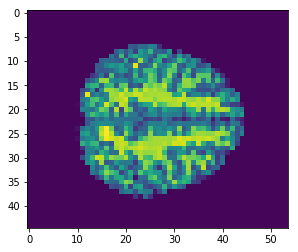

In [2]:
from matplotlib import pyplot as plt
my_slice = X[0,:,:,30,0]
%matplotlib inline
plt.imshow(my_slice, interpolation='nearest')
plt.show()

Let us now show an output from the trained model:

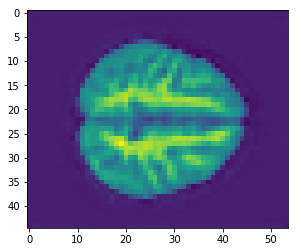

In [3]:
from matplotlib import pyplot as plt
my_slice = outs[45,:,:,30,0]
%matplotlib inline
plt.imshow(my_slice / np.max(my_slice), interpolation='nearest')
plt.show()

It is alive!